In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# Cargar el dataset
df = pd.read_csv('Datasets/ScreenTime vs MentalWellness.csv')

print("\nTipos de datos:")
print(df.dtypes)


Tipos de datos:
user_id                         object
age                              int64
gender                          object
occupation                      object
work_mode                       object
screen_time_hours              float64
work_screen_hours              float64
leisure_screen_hours           float64
sleep_hours                    float64
sleep_quality_1_5                int64
stress_level_0_10              float64
productivity_0_100             float64
exercise_minutes_per_week        int64
social_hours_per_week          float64
mental_wellness_index_0_100    float64
Unnamed: 15                    float64
dtype: object


In [3]:
# Sacamos columnas que no sirven: user_id (solo identificador) y Unnamed: 15 (columna vacia)
# La variable objetivo es sleep_quality_1_5, asi que también la separamos
X = df.drop(["user_id", "sleep_quality_1_5", "Unnamed: 15"], axis=1)

# Convertimos las columnas de texto a numeros (sklearn solo entiende numeros)
X = pd.get_dummies(X, columns=["gender", "occupation", "work_mode"], drop_first=True)
y = df['sleep_quality_1_5']

# Con esto podemos ver como aquellas features que no eran numeros, ahora si lo son
print(X.dtypes)

age                              int64
screen_time_hours              float64
work_screen_hours              float64
leisure_screen_hours           float64
sleep_hours                    float64
stress_level_0_10              float64
productivity_0_100             float64
exercise_minutes_per_week        int64
social_hours_per_week          float64
mental_wellness_index_0_100    float64
gender_Male                       bool
gender_Non-binary/Other           bool
occupation_Retired                bool
occupation_Self-employed          bool
occupation_Student                bool
occupation_Unemployed             bool
work_mode_In-person               bool
work_mode_Remote                  bool
dtype: object


In [4]:
# 80% para entrenar y 20% para evaluacion
# stratify=y mantiene la misma proporcion de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Estadisticas descriptivas
print("Descripcion de los datos de entrenamiento:\n")
print(X_train.describe())

print("\nDistribución de la variable objetivo (1=peor, 5=mejor):")
print(df['sleep_quality_1_5'].value_counts().sort_index())

Descripcion de los datos de entrenamiento:

              age  screen_time_hours  work_screen_hours  leisure_screen_hours  \
count  320.000000         320.000000         320.000000            320.000000   
mean    30.209375           8.956813           2.178187              6.778625   
std      7.757486           2.483637           1.923362              2.243773   
min     16.000000           1.000000           0.110000              0.890000   
25%     24.750000           7.335000           0.680000              5.457500   
50%     30.000000           9.010000           1.445000              6.690000   
75%     35.250000          10.392500           3.042500              8.192500   
max     60.000000          16.360000           7.540000             13.350000   

       sleep_hours  stress_level_0_10  productivity_0_100  \
count   320.000000         320.000000          320.000000   
mean      7.045094           8.115313           54.476875   
std       0.840122           2.114804      

In [5]:
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_split=15,
    min_samples_leaf=5,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# Metricas en entrenamiento y test
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# zero_division=0 debido que el dataset no esta balanceado
# por ejemplo, en el dataset no hay ninguna persona con calidad de sueño 5 (maxima)
precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

print(f"\nRendimiento en entrenamiento:")
print(f"   Accuracy: {acc_train:.4f}")

print(f"\nRendimiento en validacion:")
print(f"   Accuracy:  {acc_test:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print(f"\nCaracterísticas del arbol:")
print(f"   Profundidad: {dt.get_depth()}")
print(f"   Numero de hojas: {dt.get_n_leaves()}")
print(f"   Overfitting: {acc_train - acc_test:.4f} (diferencia train-test)")



Rendimiento en entrenamiento:
   Accuracy: 0.8844

Rendimiento en validacion:
   Accuracy:  0.8125
   Precision: 0.7719
   Recall:    0.8125
   F1-Score:  0.7894

Características del arbol:
   Profundidad: 4
   Numero de hojas: 13
   Overfitting: 0.0719 (diferencia train-test)


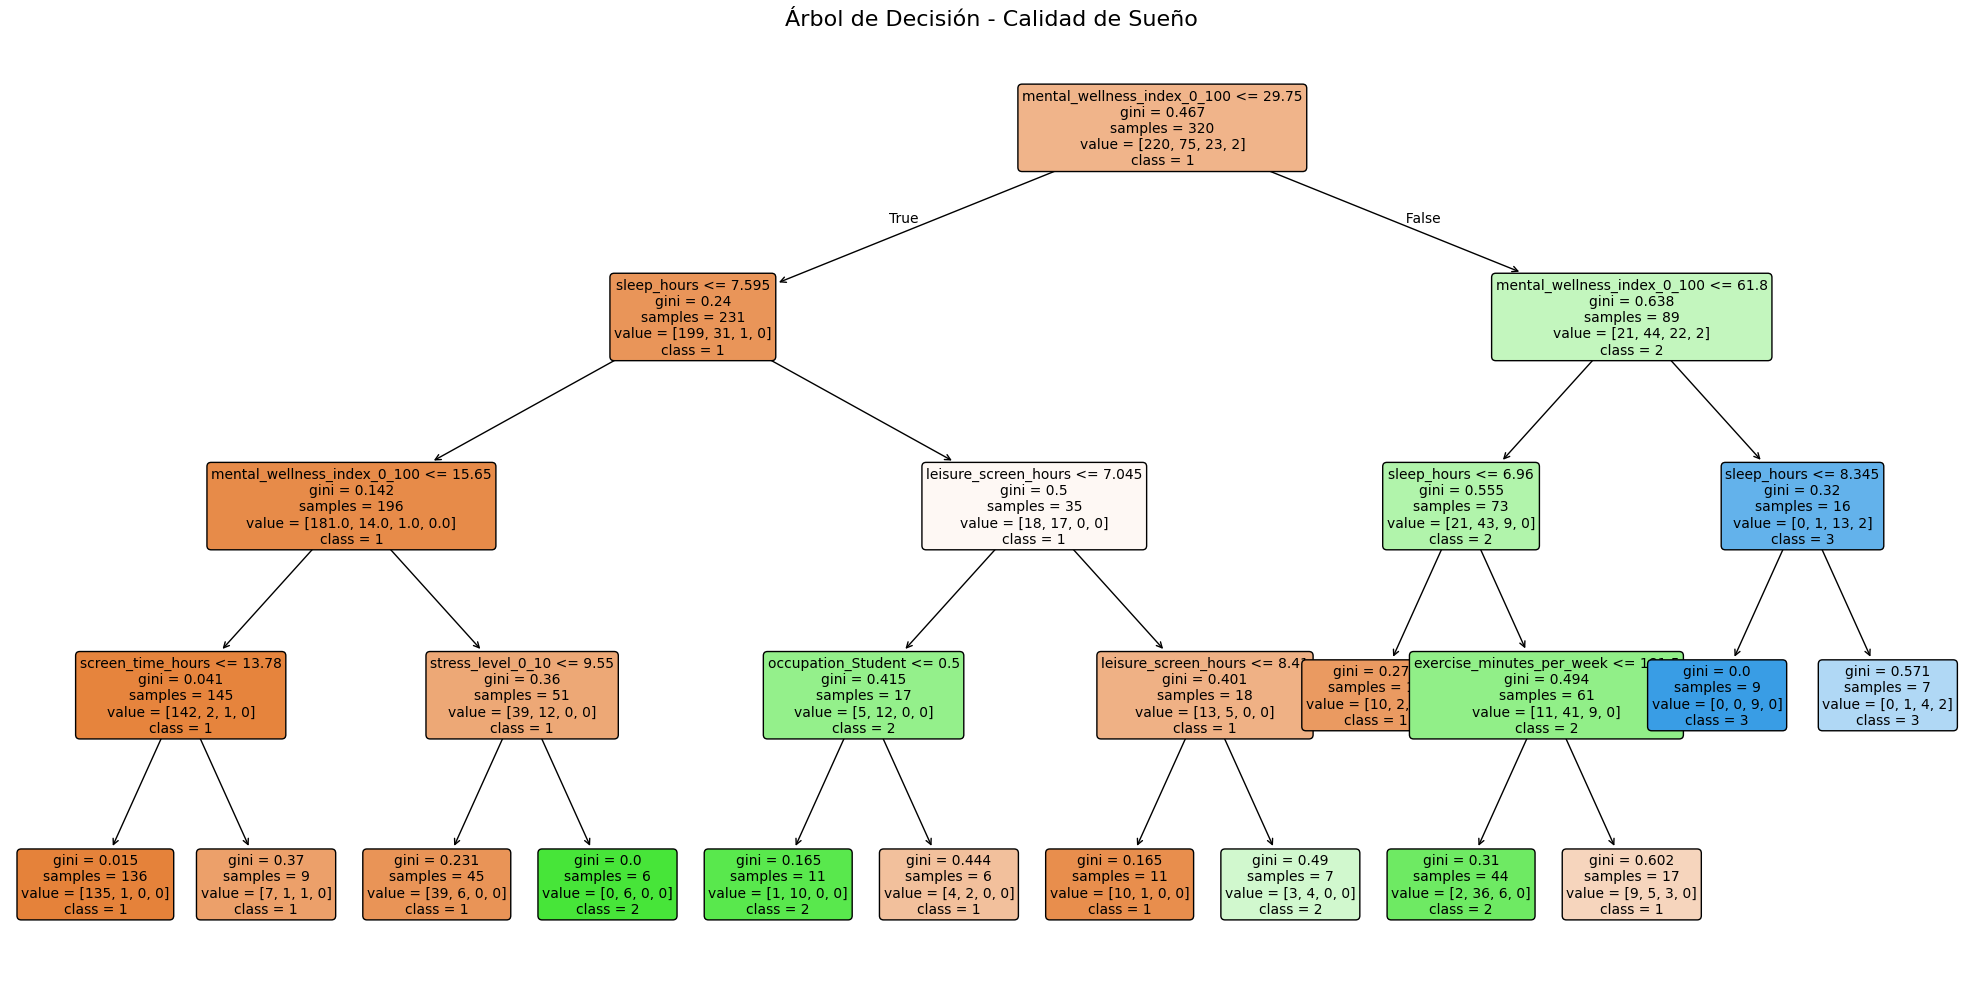

In [6]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt, 
    feature_names=X.columns,
    class_names=[str(i) for i in sorted(y.unique())],
    filled=True,           # colorea los nodos segun la clase
    rounded=True,          # bordes redondeados
    fontsize=10
)
plt.title("Árbol de Decisión - Calidad de Sueño", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
print("\nDistribución real en test:")
print(pd.Series(y_test).value_counts().sort_index())
print("\nDistribución predicha en test:")
print(pd.Series(y_pred_test).value_counts().sort_index())


Distribución real en test:
sleep_quality_1_5
1    55
2    19
3     5
4     1
Name: count, dtype: int64

Distribución predicha en test:
1    61
2    16
3     3
Name: count, dtype: int64


In [8]:
# Caracteristicas de baja calidad de sueño
baja_calidad = X_train[y_train <= 2]
print("\nCaracterísticas promedio - BAJA calidad de sueño:")
print(baja_calidad.mean())

# Caracteristicas de alta calidad de sueño
alta_calidad = X_train[y_train >= 4]
print("\nCaracterísticas promedio - ALTA calidad de sueño:")
print(alta_calidad.mean())

# Comparacion
diferencias = baja_calidad.mean() - alta_calidad.mean()
print("\nMayores diferencias:")
print(diferencias.abs().sort_values(ascending=False).head(10))


Características promedio - BAJA calidad de sueño:
age                             30.440678
screen_time_hours                9.117017
work_screen_hours                2.234949
leisure_screen_hours             6.882068
sleep_hours                      6.956407
stress_level_0_10                8.397288
productivity_0_100              52.298983
exercise_minutes_per_week      111.959322
social_hours_per_week            7.985763
mental_wellness_index_0_100     17.119322
gender_Male                      0.420339
gender_Non-binary/Other          0.027119
occupation_Retired               0.040678
occupation_Self-employed         0.111864
occupation_Student               0.247458
occupation_Unemployed            0.064407
work_mode_In-person              0.250847
work_mode_Remote                 0.386441
dtype: float64

Características promedio - ALTA calidad de sueño:
age                             25.500
screen_time_hours                6.955
work_screen_hours                0.900
leisure_sc